In [1]:
pip install torch transformers datasets textattack nltk pandas scikit-learn tensorflow sentence-transformers matplotlib seaborn joblib

In [2]:
# importing libraries
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
#from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/content/hate-speech-and-offensive-language-dataset.csv")

In [4]:
df.shape

(24783, 7)

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
# drop unusefull columns
df.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'], inplace = True)

In [7]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# check for null values
df.isnull().sum()

,0
class,0
tweet,0


In [9]:
# replace symbols and numbers from text
df["cleen_tweet"] = df["tweet"].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [10]:
df.head()

,class,tweet,cleen_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...


In [11]:
# replace multiple whitespace with one whitespace
df["cleen_tweet"] = df["cleen_tweet"].str.replace(r'\s+', ' ', regex = True)

In [12]:
df.head()

,class,tweet,cleen_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [13]:
# drop tweet column
df.drop(columns=["tweet"], inplace=True)

In [14]:
df.head()

,class,cleen_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [15]:
# load out spacy module
nlp = spacy.load("en_core_web_sm")

In [16]:
# lemmatization
def lemmatization(text):
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

df["lemma_tweet"] = df["cleen_tweet"].apply(lemmatization)

In [17]:
# remove stopwords
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

df["final_tweet"] = df["lemma_tweet"].apply(remove_stopwords)

In [18]:
df.head()

,class,cleen_tweet,lemma_tweet,final_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...,RT mayasolovely woman shouldn t complain cl...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad cuffin d...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...,RT UrKindOfBrand Dawg RT sbaby life fuck bi...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...,RT C G Anderson viva base look like tranny
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...,RT ShenikaRoberts shit hear true faker bitc...


In [19]:
# One Hot representation
vocab_size = 10000
one_hot_rep = [one_hot(words, vocab_size) for words in df["final_tweet"]]

In [20]:
# padding and embidding
sentence_length = 20
embedding_tweets = pad_sequences(one_hot_rep, padding='pre', maxlen=sentence_length)

In [21]:
# deviding dataset
X = np.array(embedding_tweets)
y = np.array(df["class"])

In [22]:
# sampling
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [23]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# create model
dimension = 50

model = keras.Sequential([
    # embidding layer
    keras.layers.Embedding(vocab_size, dimension, input_length=sentence_length),
    # LSTM Layer
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    # output layer
    keras.layers.Dense(3, activation='softmax')
])

# compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.7840 - loss: 0.5024
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.9461 - loss: 0.1672
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9642 - loss: 0.1158
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.9701 - loss: 0.0968
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 75s 36ms/step - accuracy: 0.9789 - loss: 0.0704
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.9849 - loss: 0.0527
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9880 - loss: 0.0390
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.9917 - loss: 0.0265
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.9927 - loss: 0.0212
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9948 - loss: 0.0178


In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model accuracy: {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8892 - loss: 0.5919
Model accuracy: 88.64731192588806


In [29]:
pred = np.argmax(model.predict(X_test), axis=-1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [30]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3812
           1       0.90      0.90      0.90      3807
           2       0.77      0.69      0.72       890

    accuracy                           0.89      8509
   macro avg       0.85      0.84      0.84      8509
weighted avg       0.89      0.89      0.89      8509



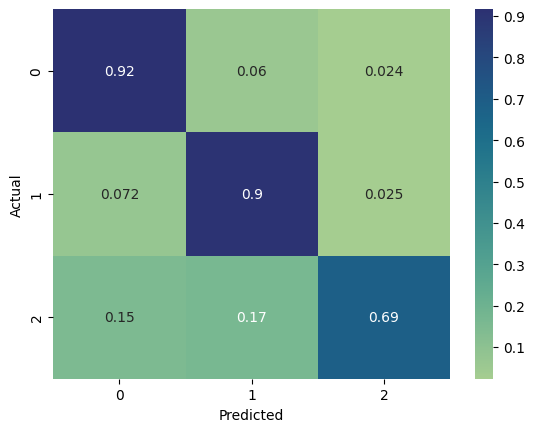

In [31]:
cf = confusion_matrix(y_test, pred, normalize='true')
sns.heatmap(cf, annot=True, cmap='crest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
# save the model
model.save('model_hate_speech.h5')